<a href="https://colab.research.google.com/github/srijoy-paul/Sound-classification/blob/main/Sound_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Connecting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing Packages

In [ ]:
import numpy as np
import cv2
import PIL.Image as Image
import os
import matplotlib.pylab as plt
import tensorflow as tf
#import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np

setting Bactch size and Image Size

In [ ]:
BATCH_SIZE = 16
IMG_SIZE = (224, 224)

Importing Training and Testing Data

In [ ]:
total_dataset = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/Soundata WAV',
                                                            shuffle=True,
                                                            seed=1,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2315 files belonging to 10 classes.


Creating Validation Data from Training Data

In [ ]:
total_batches = tf.data.experimental.cardinality(total_dataset)
print(total_batches)

tf.Tensor(145, shape=(), dtype=int64)


In [ ]:
validation_dataset = total_dataset.take(total_batches // 5)
train_dataset = total_dataset.skip(total_batches // 5)

In [ ]:
test_dataset = train_dataset.take(total_batches // 5)
train_dataset = train_dataset.skip(total_batches // 5)

Showing train, validation, and testing batches

In [ ]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of train batches: 87
Number of validation batches: 29
Number of test batches: 29


Prefetching Dataset

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.experimental.preprocessing.RandomFlip(
      mode='horizontal'
      ),
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.3),
  tf.keras.layers.RandomRotation(0.2),
])

Pre-processing the Input

In [ ]:
preprocess_input = tf.keras.applications.densenet.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Creating a Base Model

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = DenseNet121(input_shape=IMG_SHAPE,
                   include_top=False,
                   weights='imagenet')

29097984/29084464 [==============================] - 0s 0us/step


Creating Batches (image and label)

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 7, 7, 1024)


Make base Model Non-trainable

In [ ]:
base_model.trainable = False

Creatign  global average layer and Finding features

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 1024)


Creating Prediction Layer

In [ ]:
prediction_layer = tf.keras.layers.Dense(10,activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 10)


Creating Specific Layer According to the Problem

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

Getting Model Summary

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        703750

Compiling the Problem

In [ ]:
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=["acc"],
)

In [ ]:
initial_epochs = 100

#loss0, accuracy0 = model.evaluate(validation_dataset)

Running the Model

In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/100
87/87 [==============================] - 117s 1s/step - loss: 2.7348 - acc: 0.1074 - val_loss: 2.5636 - val_acc: 0.0668
Epoch 2/100
87/87 [==============================] - 9s 85ms/step - loss: 2.5285 - acc: 0.1081 - val_loss: 2.5249 - val_acc: 0.0668
Epoch 3/100
87/87 [==============================] - 9s 85ms/step - loss: 2.5241 - acc: 0.0981 - val_loss: 2.5084 - val_acc: 0.0776
Epoch 4/100
87/87 [==============================] - 9s 85ms/step - loss: 2.4821 - acc: 0.0901 - val_loss: 2.4813 - val_acc: 0.0970
Epoch 5/100
87/87 [==============================] - 9s 86ms/step - loss: 2.4675 - acc: 0.1154 - val_loss: 2.4636 - val_acc: 0.0819
Epoch 6/100
87/87 [==============================] - 9s 86ms/step - loss: 2.4588 - acc: 0.1103 - val_loss: 2.4410 - val_acc: 0.0862
Epoch 7/100
87/87 [==============================] - 9s 85ms/step - loss: 2.4642 - acc: 0.1132 - val_loss: 2.4145 - val_acc: 0.0927
Epoch 8/100
87/87 [==============================] - 10s 87ms/step - loss: 2

Evaluate the Dataset

In [ ]:
model.evaluate(test_dataset)

29/29 [==============================] - 3s 60ms/step - loss: 2.0208 - acc: 0.2759


[2.020820140838623, 0.27586206793785095]

Save the Model in Drive

In [ ]:
model.save('/content/drive/MyDrive/Result_Sound_Numeral/DenseNet121_sound.hdf5')

Reload the Model from Google Drive

In [ ]:
from tensorflow import keras
model_load = keras.models.load_model('/content/drive/MyDrive/Result_Sound_Numeral/DenseNet121_sound.hdf5')

Evaluate the Model

In [ ]:
model_load.evaluate(test_dataset)

28/28 [==============================] - 20s 289ms/step - loss: 2.1356 - acc: 0.2232


[2.135566234588623, 0.2232142835855484]

Accuracy and Loss Graph

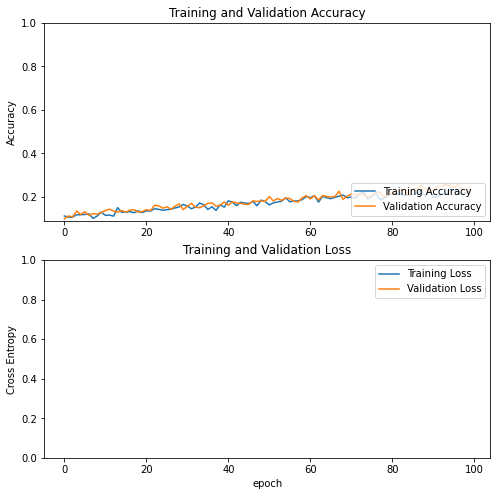

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
#plt.save('/content/drive/MyDrive/vgg16_veg_acc.png')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('/content/drive/MyDrive/Result_Sound_Numeral/DenseNet121_sound_acc_loss.png')
plt.show()

Make Base Model Trainable

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Train the Base Model from a Specific Layer

In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 385

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Recompile the Model

In [ ]:
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['acc'])

Fine Tune the Model and Running the Model

In [ ]:
fine_tune_epochs = 40
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Evaluate the Model

In [ ]:
model.evaluate(test_dataset)

Save the Fine Tuned Model

In [ ]:
model.save('/content/drive/MyDrive/vegIdentification_result/model_DenseNet121_fineTune_veg385.hdf5')

Reload the Fine Tuned Model

In [ ]:
from tensorflow import keras
modelfinetune_load = keras.models.load_model('/content/drive/MyDrive/vegIdentification_result/model_DenseNet121_fineTune_veg385.hdf5')

Evaluate the Model

In [ ]:
modelfinetune_load.evaluate(test_dataset)

In [ ]:
acc=acc[:100]

In [ ]:
val_acc=val_acc[:100]

In [ ]:
loss=loss[:100]
val_loss=val_loss[:100]

Accuracy and Loss Graph of Finetuned Model

In [ ]:
acc += history_fine.history['acc']
val_acc += history_fine.history['val_acc']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.2, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('/content/drive/MyDrive/vegIdentification_result/DenseNet121finetune_veg_acc_loss_385.png')
plt.show()